In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 

In [2]:
spark = SparkSession \
    .builder \
    .appName("Clustering en Spark") \
    .getOrCreate()

In [3]:
%%time
#table = spark.read.option("header", True).csv("gs://big-data-up/steam_reviews.csv")
#table = spark.read.format('csv')\
    #.option('header',True)\ #el archivo tiene header?
    #.option("delimiter", ",")\ #que delimita las columnas?
    #.option("multiline", True)\  #permite varias líneas para el mismo registro?
    #.option("escape", '"')\ #este valor escapa strings, lo que venga hasta el siguiente se considerará una sola columna
    #.option("inferSchema", "true")\ #suponer el esquema, esto hace que tarde mas la carga
#.load("gs://big-data-up/steam_reviews.csv")
table = spark.read.format('csv')\
    .option('header',True)\
    .option("delimiter", ",")\
    .option("multiline", True)\
    .option("escape", '"')\
    .option("inferSchema", "true")\
.load("gs://big-data-up/steam_reviews.csv")

#por que se lee así?, el review tiene comas, pero viene delimitado por comillas dobles ". 

CPU times: user 27.3 ms, sys: 7.82 ms, total: 35.1 ms
Wall time: 2min 27s


In [4]:
table.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- app_id: integer (nullable = true)
 |-- app_name: string (nullable = true)
 |-- review_id: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: integer (nullable = true)
 |-- timestamp_updated: long (nullable = true)
 |-- recommended: boolean (nullable = true)
 |-- votes_helpful: long (nullable = true)
 |-- votes_funny: long (nullable = true)
 |-- weighted_vote_score: double (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- steam_purchase: boolean (nullable = true)
 |-- received_for_free: boolean (nullable = true)
 |-- written_during_early_access: boolean (nullable = true)
 |-- author.steamid: long (nullable = true)
 |-- author.num_games_owned: long (nullable = true)
 |-- author.num_reviews: long (nullable = true)
 |-- author.playtime_forever: double (nullable = true)
 |-- author.playtime_last_two_weeks: double (nullable = true)
 |-- author.playtime

In [5]:
#notar el backtick `, por que las columnas tienen ".", entonces hay que leerlas como string raw
english = table.select("review","recommended","weighted_vote_score","comment_count","received_for_free","written_during_early_access", col("`author.num_games_owned`").alias("num_games_owned"), col("`author.num_reviews`").alias("num_reviews"), \
                col("`author.playtime_forever`").alias("playtime_forever"), col("`author.playtime_at_review`").alias("playtime_at_review"))\
.filter((table.language == "english") & (table.weighted_vote_score > 0) & (table.comment_count.isNotNull()) & (table.received_for_free.isNotNull()) & \
                    (table.written_during_early_access.isNotNull()))

english = english.filter(english.num_games_owned.isNotNull() & english.num_reviews.isNotNull() & english.playtime_forever.isNotNull() & english.playtime_at_review.isNotNull())

english.show()

# ['comment_count', 'received_for_free', 'written_during_early_access', "num_games_owned", 'num_reviews', 'playtime_forever', 'playtime_at_review']


+--------------------+-----------+-------------------+-------------+-----------------+---------------------------+---------------+-----------+----------------+------------------+
|              review|recommended|weighted_vote_score|comment_count|received_for_free|written_during_early_access|num_games_owned|num_reviews|playtime_forever|playtime_at_review|
+--------------------+-----------+-------------------+-------------+-----------------+---------------------------+---------------+-----------+----------------+------------------+
|They certainly du...|      false| 0.4761904776096344|            0|            false|                      false|            379|         73|          8966.0|            8966.0|
|A masterpiece, be...|       true|  0.523809552192688|            0|            false|                      false|             24|          1|          5860.0|            5860.0|
|          awesomness|       true|  0.474452555179596|            0|            false|                   

In [6]:
english.count()

3197027

In [7]:
english.printSchema()

root
 |-- review: string (nullable = true)
 |-- recommended: boolean (nullable = true)
 |-- weighted_vote_score: double (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- received_for_free: boolean (nullable = true)
 |-- written_during_early_access: boolean (nullable = true)
 |-- num_games_owned: long (nullable = true)
 |-- num_reviews: long (nullable = true)
 |-- playtime_forever: double (nullable = true)
 |-- playtime_at_review: double (nullable = true)



In [8]:
#veremos si las recomendaciones positivas tienen que ver con elementos externos.

In [9]:
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

In [10]:
cols = ['comment_count', 'received_for_free', 'written_during_early_access', "num_games_owned", 'num_reviews', 'playtime_forever', 'playtime_at_review']
vecAssembler = VectorAssembler(inputCols = cols, outputCol = "rawFeatures")
df = vecAssembler.transform(english)
df.show(5)

+--------------------+-----------+-------------------+-------------+-----------------+---------------------------+---------------+-----------+----------------+------------------+--------------------+
|              review|recommended|weighted_vote_score|comment_count|received_for_free|written_during_early_access|num_games_owned|num_reviews|playtime_forever|playtime_at_review|         rawFeatures|
+--------------------+-----------+-------------------+-------------+-----------------+---------------------------+---------------+-----------+----------------+------------------+--------------------+
|They certainly du...|      false| 0.4761904776096344|            0|            false|                      false|            379|         73|          8966.0|            8966.0|[0.0,0.0,0.0,379....|
|A masterpiece, be...|       true|  0.523809552192688|            0|            false|                      false|             24|          1|          5860.0|            5860.0|[0.0,0.0,0.0,24.0...|


In [11]:
%%time
scaler = StandardScaler(inputCol = "rawFeatures", outputCol = "features", withStd = True, withMean = True)
scalerModel = scaler.fit(df)
normalData = scalerModel.transform(df)
normalData.select("features").show(10, False)

+----------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                            |
+----------------------------------------------------------------------------------------------------------------------------------------------------+
|[-0.10016381263573049,-0.18362258356316413,-0.37257867947630763,0.37887545715308163,1.0593330366921476,-0.20482754771813594,-0.021816428814255603]  |
|[-0.10016381263573049,-0.18362258356316413,-0.37257867947630763,-0.4662088919557702,-0.2996731302784778,-0.26790308150618614,-0.12932106795615445]  |
|[-0.10016381263573049,-0.18362258356316413,-0.37257867947630763,-0.4685894112490346,-0.20529770201662884,-0.37557419552558147,-0.325709130574034]   |
|[-0.10016381263573049,-0.18362258356316413,-0.37257867947630763,-0.2686257906148274,-0.280798

In [12]:
%%time
from pyspark.ml.clustering import KMeans
kmeans = KMeans().setK(6).setSeed(2^31-1)
model = kmeans.fit(normalData.select("features"))

#este es un buen punto para explicar, que el K se escogió al azar.


22/04/18 19:36:44 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/04/18 19:36:44 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


CPU times: user 57.4 ms, sys: 25.7 ms, total: 83.2 ms
Wall time: 4min 34s


In [13]:
model

KMeansModel: uid=KMeans_3dafe60fd39a, k=6, distanceMeasure=euclidean, numFeatures=7

In [14]:
model.clusterCenters()

[array([-1.76042443e-03,  5.44595152e+00, -6.39154238e-02, -1.83716682e-01,
        -3.61835911e-02, -9.71957483e-02, -1.21363357e-01]),
 array([-0.01615525, -0.18362258,  0.00965921, -0.04971687, -0.03926779,
        -0.17998094, -0.16942128]),
 array([ 0.01772289, -0.17883295, -0.0753592 , -0.18133573, -0.17701111,
         2.13174549,  1.93787855]),
 array([ 0.17884507, -0.06450593, -0.16057841, -0.11000179, -0.16975156,
         9.20846618,  9.75339273]),
 array([40.91852413, -0.04437517,  0.09184786,  0.4295393 ,  0.15206169,
         0.68008065,  0.70265376]),
 array([ 0.17991291, -0.08044859, -0.14316142,  6.13584456,  4.73591556,
        -0.24935265, -0.20604265])]

In [15]:
%%time
#viendo el cluster
from pyspark.ml.evaluation import ClusteringEvaluator

result = model.transform(normalData.select("features")) 
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(result)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.7408686798020486
CPU times: user 24.8 ms, sys: 28.1 ms, total: 52.9 ms
Wall time: 3min 6s


In [16]:
%%time
from pyspark.ml.feature import PCA

pca = PCA(k = 2, inputCol = "features", outputCol="pcaFeatures")
pcaModel = pca.fit(result)
resultPCA = pcaModel.transform(result)

22/04/18 19:44:36 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/04/18 19:44:37 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


CPU times: user 37.6 ms, sys: 17.6 ms, total: 55.1 ms
Wall time: 3min 10s


In [17]:
%%time
x = resultPCA.select(["prediction", "pcaFeatures"]).toPandas()

CPU times: user 59.8 s, sys: 1.61 s, total: 1min 1s
Wall time: 2min 34s


In [18]:
x

,prediction,pcaFeatures
0,1,"[0.30752857045803556, -0.9983672896854683]"
1,1,"[0.1843210899606449, 0.5376668405770747]"
2,1,"[0.4069544508635915, 0.5060093794160677]"
3,1,"[0.04768865341459358, 0.36417506015756046]"
4,1,"[0.4002267753776827, 0.2070521518057636]"
...,...,...
3197022,1,"[0.3931920427356942, 0.17829188950718222]"
3197023,1,"[0.49142836341176743, -0.6108056552450668]"
3197024,1,"[0.42601269168090394, 0.3842858715654217]"
3197025,1,"[0.41835473011686886, 0.2676751451049362]"


In [19]:
labels = x.values[:,0]
fts = x.values[:,1]

In [20]:
%%time
import pandas as pd
x1 = pd.Series(fts).map(lambda s: s[0])
x2 = pd.Series(fts).map(lambda s: s[1])

CPU times: user 4.39 s, sys: 140 ms, total: 4.53 s
Wall time: 4.53 s


CPU times: user 400 ms, sys: 59.7 ms, total: 460 ms
Wall time: 757 ms


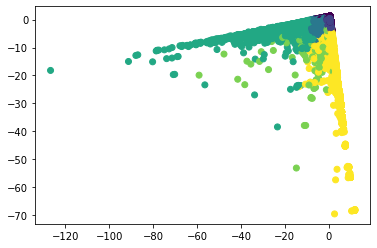

In [21]:
%%time
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(x1, x2, c = labels)

In [23]:
%%time
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(result)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.7408686798020486
CPU times: user 32.6 ms, sys: 9.34 ms, total: 41.9 ms
Wall time: 3min 2s
